In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
import scipy

from qiskit import QuantumCircuit, transpile, QuantumRegister, BasicAer, execute
from qiskit.quantum_info import Statevector
from qiskit.aqua.components.optimizers import COBYLA, SLSQP
from qiskit.extensions import Initialize

from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator

/home/chemac/anaconda3/envs/chemproject/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.0) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# 1. VQE using UCCSD for H2

In [2]:
map_type = 'jordan_wigner'

def get_qubit_op(dist):
    driver = PySCFDriver(atom="H .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    shift =  repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [3]:
backend = BasicAer.get_backend("statevector_simulator")

#distance from 0.3 to 3.1 focus on 0.7 to 0.8
distances = np.arange(0.3,0.7,0.1)
distances = np.append(distances, np.arange(0.7,0.8,0.005))
distances = np.append(distances, np.arange(0.8,3.1,0.1))
exact_energies = []
UCCSD_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping=map_type,
        two_qubit_reduction=False
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping=map_type,
        two_qubit_reduction=False
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    UCCSD_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 4), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1][0])
    
print("All energies have been calculated")

Interatomic Distance: 0.3 VQE Result: -0.6018037107598917 Exact Energy: -0.6018037107656813
Interatomic Distance: 0.4 VQE Result: -0.9141497046155878 Exact Energy: -0.914149704627079
Interatomic Distance: 0.5 VQE Result: -1.0551597944480011 Exact Energy: -1.0551597944706186
Interatomic Distance: 0.6 VQE Result: -1.1162860068309657 Exact Energy: -1.116286006869541
Interatomic Distance: 0.7 VQE Result: -1.1361894540115212 Exact Energy: -1.1361894540659256
Interatomic Distance: 0.705 VQE Result: -1.1364956747995507 Exact Energy: -1.136495674854822
Interatomic Distance: 0.71 VQE Result: -1.1367503972276471 Exact Energy: -1.1367503972832071
Interatomic Distance: 0.715 VQE Result: -1.1369552252005692 Exact Energy: -1.1369552252566222
Interatomic Distance: 0.72 VQE Result: -1.1371117150590462 Exact Energy: -1.1371117151154684
Interatomic Distance: 0.725 VQE Result: -1.1372213770152055 Exact Energy: -1.1372213770723012
Interatomic Distance: 0.73 VQE Result: -1.1372856765402286 Exact Energy: -1

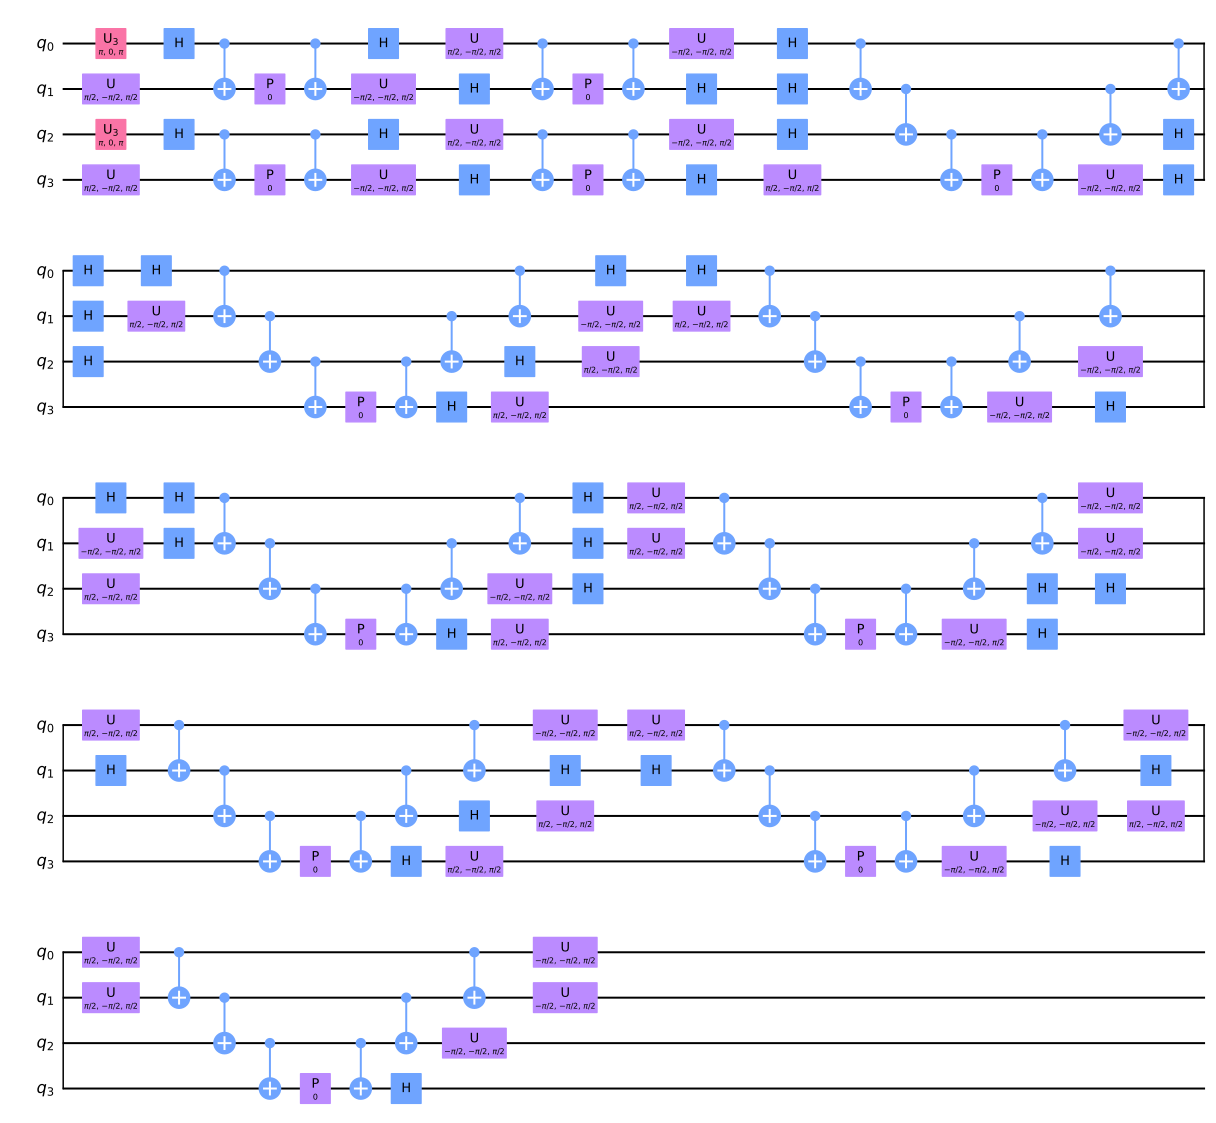

In [4]:
var_form.construct_circuit([0]*3).decompose().draw('mpl')

In [5]:
error_UCCSD = []
for i in range(len(exact_energies)):
    error_UCCSD.append(627.509*abs(exact_energies[i]-UCCSD_energies[i]))

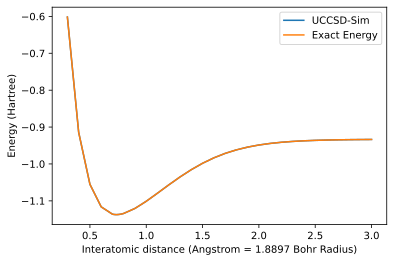

In [6]:
plt.plot(distances, UCCSD_energies, label="UCCSD-Sim")
plt.plot(distances, exact_energies, label="Exact Energy")
plt.xlabel('Interatomic distance (Angstrom = 1.8897 Bohr Radius)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

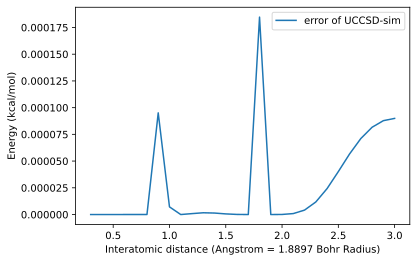

In [7]:
plt.plot(distances, error_UCCSD, label="error of UCCSD-sim")
plt.xlabel('Interatomic distance (Angstrom = 1.8897 Bohr Radius)')
plt.ylabel('Energy (kcal/mol)')
plt.legend()
plt.show()

# 2. VQE using Initilize Ansatz for H2

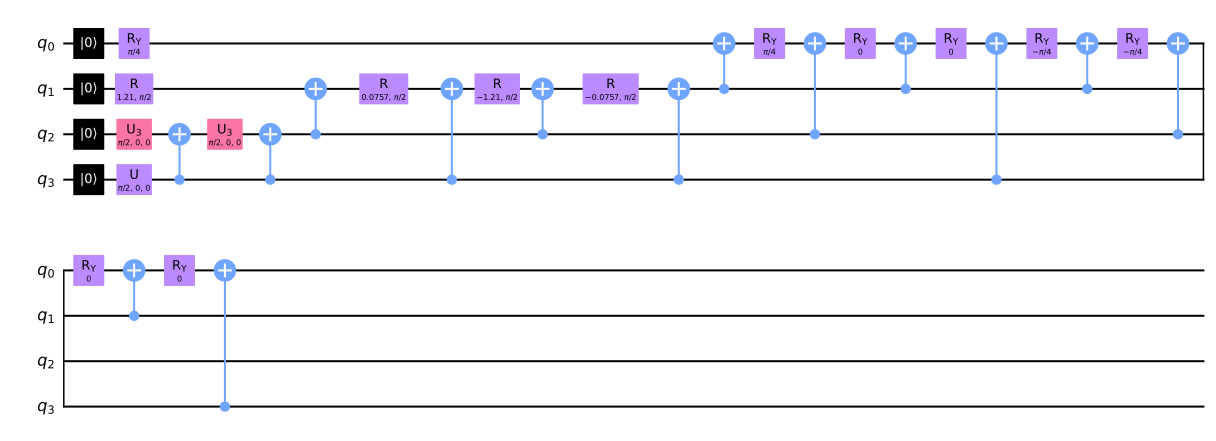

In [8]:
# Notice that the depth of the circuit is much shorter than that of the UCCSD Ansatz
sv = Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.3 +0.j, 0.6403124237+0.j,
                  0.+0.j, 0.+0.j, 0.2+0.j, 0.6782329983+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
                  0.+0.j, 0.+0.j],
                  dims=(2, 2, 2, 2))

qc = QuantumCircuit(4)
qc.initialize(sv.data, [0, 1, 2, 3])
qc.decompose().decompose().decompose().decompose().decompose().decompose().draw('mpl')

In [9]:
backend = BasicAer.get_backend("statevector_simulator")
def vqe_result_initialize(statevector_params):
    """
    A list containing the four parameters in the statevecotr as input,
    return the energy that has to be optimize
    """
    #normalize the statevector (will fail if norm = 0)
    statevector_params = statevector_params/np.sqrt(np.sum(statevector_params**2))
    
    # Build the statevector and quantum circuit according to the parameters
    sv = Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, statevector_params[0], statevector_params[1],
                      0.+0.j, 0.+0.j, statevector_params[2], statevector_params[3], 0.+0.j, 0.+0.j, 0.+0.j,
                      0.+0.j, 0.+0.j], dims=(2, 2, 2, 2))
    qc = QuantumCircuit(4)
    qc.initialize(sv.data, [0, 1, 2, 3])
    
    # Construct the evaluation circuits and excute the job
    evaluation_circuits = qubitOp.construct_evaluation_circuit(qc,True)
    job = execute(evaluation_circuits, backend)
    result = job.result()
    
    # Evaluate the result and account the nuclear repulsion(shift) in the total energy
    energy = qubitOp.evaluate_with_result(result, True)[0].real + shift
    return energy

In [10]:
Initialize_energies = []
i = 0
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = scipy.optimize.minimize(vqe_result_initialize, np.array([0.9932215467772475, 0, 0, -0.116236650921350]), method="COBYLA")
    final_energy = result.fun
    Initialize_energies.append(final_energy)
    print("Interatomic Distance:", np.round(dist, 4), "VQE Result:", final_energy, "Exact Energy:", exact_energies[i][0])
    i += 1
print("All energies have been calculated")

Interatomic Distance: 0.3 VQE Result: -0.6018037043088622 Exact Energy: -0.6018037107656813
Interatomic Distance: 0.4 VQE Result: -0.914149698023035 Exact Energy: -0.914149704627079
Interatomic Distance: 0.5 VQE Result: -1.055159793408383 Exact Energy: -1.0551597944706186
Interatomic Distance: 0.6 VQE Result: -1.1162860031904414 Exact Energy: -1.116286006869541
Interatomic Distance: 0.7 VQE Result: -1.1361894276795992 Exact Energy: -1.1361894540659256
Interatomic Distance: 0.705 VQE Result: -1.1364956667788475 Exact Energy: -1.136495674854822
Interatomic Distance: 0.71 VQE Result: -1.1367503692016412 Exact Energy: -1.1367503972832071
Interatomic Distance: 0.715 VQE Result: -1.136955214232315 Exact Energy: -1.1369552252566222
Interatomic Distance: 0.72 VQE Result: -1.137111694459169 Exact Energy: -1.1371117151154684
Interatomic Distance: 0.725 VQE Result: -1.137221372588112 Exact Energy: -1.1372213770723012
Interatomic Distance: 0.73 VQE Result: -1.1372856710826804 Exact Energy: -1.1372

In [11]:
error_Initialize = []
for i in range(len(exact_energies)):
    error_Initialize.append(627.509*abs(exact_energies[i]-Initialize_energies[i]))

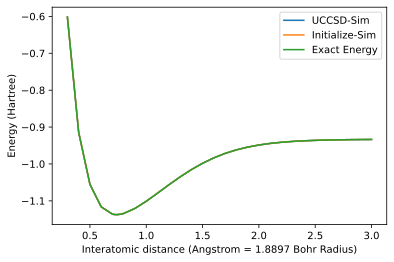

In [12]:
plt.plot(distances, UCCSD_energies, label="UCCSD-Sim")
plt.plot(distances, Initialize_energies, label="Initialize-Sim")
plt.plot(distances, exact_energies, label="Exact Energy")
plt.xlabel('Interatomic distance (Angstrom = 1.8897 Bohr Radius)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

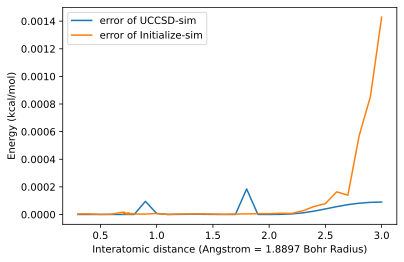

In [13]:
plt.plot(distances, error_UCCSD, label="error of UCCSD-sim")
plt.plot(distances, error_Initialize, label="error of Initialize-sim")
plt.xlabel('Interatomic distance (Angstrom = 1.8897 Bohr Radius)')
plt.ylabel('Energy (kcal/mol)')
plt.legend()
plt.show()

# 3. VQE using UCCSD for LiH

In [14]:
map_type = 'jordan_wigner'

def get_qubit_op_LiH(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [15]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies_LiH = []
UCCSD_energies_LiH = []
optimizer = COBYLA(maxiter=1000)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op_LiH(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies_LiH.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping=map_type,
        two_qubit_reduction=False
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping=map_type,
        two_qubit_reduction=False
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    UCCSD_energies_LiH.append(vqe_result)
    print("Interatomic Distance:", np.round(dist,2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies_LiH[-1][0])
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.03973246056419 Exact Energy: -7.039732521635204
Interatomic Distance: 0.6 VQE Result: -7.313345812242154 Exact Energy: -7.313345828761006
Interatomic Distance: 0.7 VQE Result: -7.500922063296078 Exact Energy: -7.500922090905931
Interatomic Distance: 0.8 VQE Result: -7.630978235574324 Exact Energy: -7.630978249333207
Interatomic Distance: 0.9 VQE Result: -7.720812398369539 Exact Energy: -7.720812412134782
Interatomic Distance: 1.0 VQE Result: -7.7822423916031855 Exact Energy: -7.782242402637013
Interatomic Distance: 1.1 VQE Result: -7.823599261270583 Exact Energy: -7.823599276362816
Interatomic Distance: 1.2 VQE Result: -7.850698363310062 Exact Energy: -7.850698377596025
Interatomic Distance: 1.3 VQE Result: -7.867563277883358 Exact Energy: -7.867563290110051
Interatomic Distance: 1.4 VQE Result: -7.877001481732178 Exact Energy: -7.877001491818372
Interatomic Distance: 1.5 VQE Result: -7.8810156893722 Exact Energy: -7.88101571564699
Interatomic D

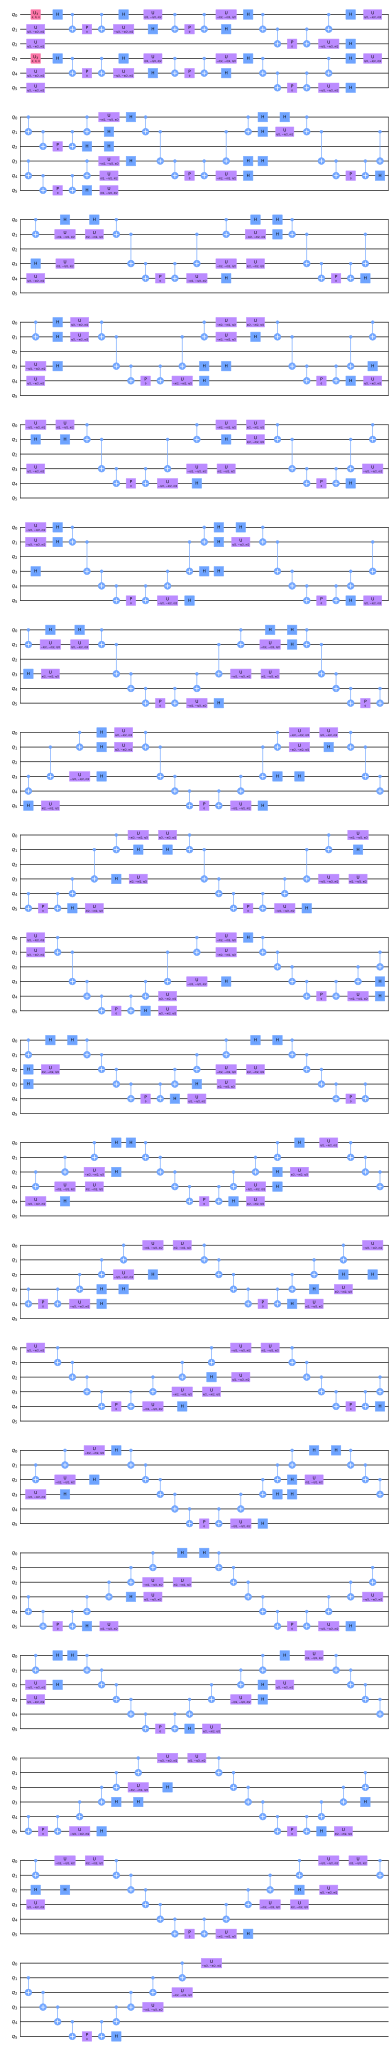

In [16]:
var_form.construct_circuit([0]*8).decompose().draw('mpl')

In [17]:
error_UCCSD_LiH = []
for i in range(len(exact_energies_LiH)):
    error_UCCSD_LiH.append(627.509*abs(exact_energies_LiH[i]-UCCSD_energies_LiH[i]))

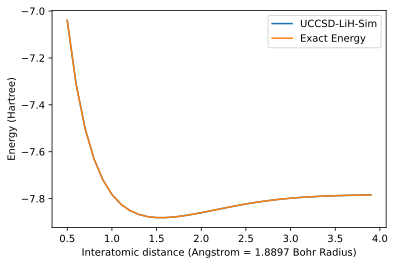

In [18]:
plt.plot(distances, UCCSD_energies_LiH, label="UCCSD-LiH-Sim")
plt.plot(distances, exact_energies_LiH, label="Exact Energy")
plt.xlabel('Interatomic distance (Angstrom = 1.8897 Bohr Radius)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

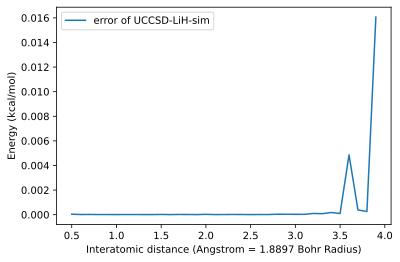

In [19]:
plt.plot(distances, error_UCCSD_LiH, label="error of UCCSD-LiH-sim")
plt.xlabel('Interatomic distance (Angstrom = 1.8897 Bohr Radius)')
plt.ylabel('Energy (kcal/mol)')
plt.legend()
plt.show()

# 4. VQE using Initilize Ansatz for LiH

In [20]:
backend = BasicAer.get_backend("statevector_simulator")
def vqe_result_initialize_LiH(statevector_params):
    """
    A list containing the nine parameters in the statevecotr as input,
    return the energy that has to be optimize
    """
    #normalize the statevector (will fail if norm = 0)
    statevector_params = statevector_params/np.sqrt(np.sum(statevector_params**2))
    
    # Build the statevector and quantum circuit according to the parameters
    sv = Statevector([ 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,  
                       statevector_params[0], statevector_params[1], 0.+0.j, statevector_params[2], 
                       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, statevector_params[3], statevector_params[4], 
                       0.+0.j, statevector_params[5], 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 
                       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, statevector_params[6], 
                       statevector_params[7], 0.+0.j, statevector_params[8], 0.+0.j, 0.+0.j, 
                       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 
                       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 
                       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j], dims=(2, 2, 2, 2, 2, 2))
    qc = QuantumCircuit(6)
    qc.initialize(sv.data, [0, 1, 2, 3, 4, 5])
    
    # Construct the evaluation circuits and excute the job
    evaluation_circuits = qubitOp.construct_evaluation_circuit(qc, True)
    job = execute(evaluation_circuits, backend)
    result = job.result()
    
    # Evaluate the result and account the nuclear repulsion(shift) in the total energy
    energy = qubitOp.evaluate_with_result(result, True)[0].real + shift
    return energy

In [21]:
distances = np.arange(0.5, 4.0, 0.1)
Initialize_energies_LiH = []
#initial point from the parameters of LiH UCCSD at the interatomic disdance 1.6 Angstrom
initial_point = np.array([0.987713, 0.034231, 0.005294, 0.034395, -0.037551, 
                          0.060425, 0.005332, 0.060322, -0.115379])

# This will take a while to finish
i = 0
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op_LiH(dist)
    result = scipy.optimize.minimize(vqe_result_initialize_LiH, initial_point, method="COBYLA")
    final_energy = result.fun
    Initialize_energies_LiH.append(final_energy)
    print("Interatomic Distance:", np.round(dist, 4), "VQE Result:", final_energy, "Exact Energy:", exact_energies_LiH[i][0])
    i += 1
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.039732504768534 Exact Energy: -7.039732521635204
Interatomic Distance: 0.6 VQE Result: -7.313345723025795 Exact Energy: -7.313345828761006
Interatomic Distance: 0.7 VQE Result: -7.500922065295564 Exact Energy: -7.500922090905931
Interatomic Distance: 0.8 VQE Result: -7.630978246473987 Exact Energy: -7.630978249333207
Interatomic Distance: 0.9 VQE Result: -7.720812384325332 Exact Energy: -7.720812412134782
Interatomic Distance: 1.0 VQE Result: -7.782242391347258 Exact Energy: -7.782242402637013
Interatomic Distance: 1.1 VQE Result: -7.823599272322981 Exact Energy: -7.823599276362816
Interatomic Distance: 1.2 VQE Result: -7.850698374865517 Exact Energy: -7.850698377596025
Interatomic Distance: 1.3 VQE Result: -7.867563263855412 Exact Energy: -7.867563290110051
Interatomic Distance: 1.4 VQE Result: -7.8770014688920345 Exact Energy: -7.877001491818372
Interatomic Distance: 1.5 VQE Result: -7.881015707491579 Exact Energy: -7.88101571564699
Interatomi

In [22]:
error_Initialize_LiH = []
for i in range(len(exact_energies_LiH)):
    error_Initialize_LiH.append(627.509*abs(exact_energies_LiH[i]-Initialize_energies_LiH[i]))

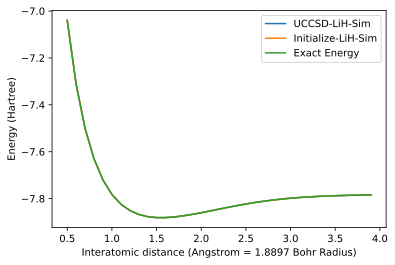

In [23]:
plt.plot(distances, UCCSD_energies_LiH, label="UCCSD-LiH-Sim")
plt.plot(distances, Initialize_energies_LiH, label="Initialize-LiH-Sim")
plt.plot(distances, exact_energies_LiH, label="Exact Energy")
plt.xlabel('Interatomic distance (Angstrom = 1.8897 Bohr Radius)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

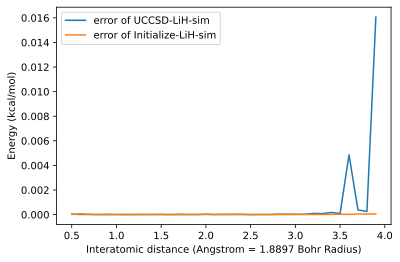

In [24]:
plt.plot(distances, error_UCCSD_LiH, label="error of UCCSD-LiH-sim")
plt.plot(distances, error_Initialize_LiH, label="error of Initialize-LiH-sim")
plt.xlabel('Interatomic distance (Angstrom = 1.8897 Bohr Radius)')
plt.ylabel('Energy (kcal/mol)')
plt.legend()
plt.show()